# Settings

In [1]:
is_plot = True
is_export = True

landmarks_path = '/Users/knpob/Territory/2-Kolmo/4-Dataset/20230715-DynaBreastLite/landmark/landmark.pkl'
meshes_path = '/Users/knpob/Territory/2-Kolmo/4-Dataset/20230715-DynaBreastLite/mesh/'

start=0
stride = 12
end=120

export_folder = "../output/dataset/"

# Data loading

In [2]:
from mesh4d import obj3d

mesh_ls, texture_ls = obj3d.load_mesh_series(
    folder=meshes_path,
    start=start,
    stride=stride,
    end=end,
)

[====================] 100.0% loading: /Users/knpob/Territory/2-Kolmo/4-Dataset/20230715-DynaBreastLite/mesh/speed_6km_h_26_marker_set_.000121.obj


In [3]:
import numpy as np

def parse_vertex_color(mesh, texture) -> tuple:
    texture_img = np.array(texture.to_array())
    u, v = mesh.active_t_coords.T
    v_mapped = np.round((1 - v) * (texture_img.shape[0] - 1)).astype(int)
    u_mapped = np.round(u * (texture_img.shape[1] - 1)).astype(int)
    
    color_ls = texture_img[v_mapped, u_mapped]
    vertex_ls = np.array(mesh.points)
        
    return color_ls, vertex_ls

In [4]:
color_ls, vertex_ls = parse_vertex_color(mesh_ls[0], texture_ls[0])
color_ls, vertex_ls

(array([[154, 126, 114],
        [145, 117, 106],
        [151, 121, 111],
        ...,
        [ 21,  24,  31],
        [ 21,  24,  33],
        [ 19,  22,  27]], dtype=uint8),
 array([[-230.71396,  509.28302,  126.48398],
        [-233.60876,  508.64197,  123.54577],
        [-233.55063,  504.9501 ,  125.82991],
        ...,
        [-192.54497, -513.7274 , -310.2367 ],
        [-169.79843, -513.8048 , -307.53976],
        [-187.8677 , -512.9751 , -327.03302]], dtype=float32))

# Separating points based on its gray scale

## Gray scale threshold

In [5]:
gray_ls = np.sum(color_ls * [0.299, 0.587, 0.114], axis=1)
gray_ls

array([133.004, 124.118, 128.83 , ...,  23.901,  24.129,  21.673])

In [6]:
mesh_ls[0]['grayscale'] = gray_ls
mesh_ls[0].plot(cmap='gray')

Widget(value="<iframe src='http://localhost:55120/index.html?ui=P_0x7f8e2cdebdc0_0&reconnect=auto' style='widt…

'std 67.20635929431904 mean 93.54956854931413 min 0.929 max 255.0'

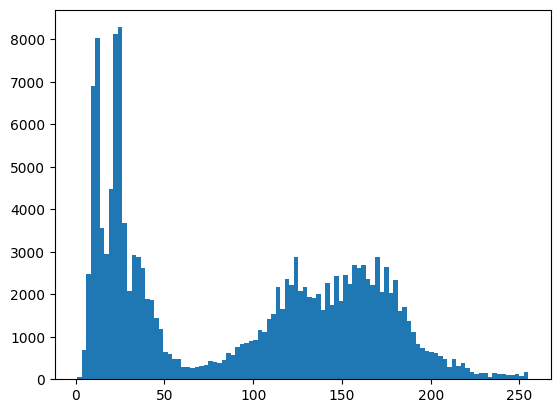

In [47]:
import matplotlib.pyplot as plt
plt.hist(gray_ls, bins=100)
f"std {np.std(gray_ls)} mean {np.mean(gray_ls)} min {np.min(gray_ls)} max {np.max(gray_ls)}"

In [80]:
import pyvista as pv

scene = pv.Plotter()
cloud = pv.PolyData(vertex_ls[gray_ls < 255/3])
scene.add_mesh(cloud, point_size=5)
scene.add_mesh(mesh_ls[0])
scene.camera_position = 'xy'
scene.show()

Widget(value="<iframe src='http://localhost:55120/index.html?ui=P_0x7f8dd8179f70_25&reconnect=auto' style='wid…

# Local gray scale difference

In [81]:
from scipy.spatial import KDTree

tree = KDTree(vertex_ls)
_, idx = tree.query(vertex_ls, 10)

'std 19.731864460550145 mean 8.929875941962345 min 0.0 max 234.43399999999997'

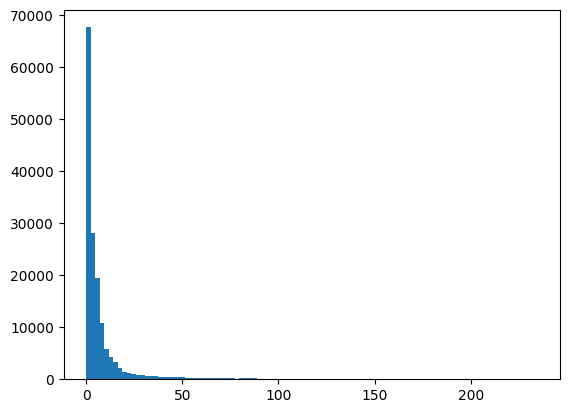

In [82]:
near_diff = np.max(np.abs(gray_ls[idx]  - np.expand_dims(gray_ls, axis=-1)), axis=1)
plt.hist(near_diff, bins=100)

mean = np.mean(near_diff)
std = np.std(near_diff)

f"std {np.std(near_diff)} mean {np.mean(near_diff)} min {np.min(near_diff)} max {np.max(near_diff)}"

In [83]:
import pyvista as pv

scene = pv.Plotter()
cloud = pv.PolyData(vertex_ls[near_diff > mean + 2 * std])
scene.add_mesh(cloud, point_size=5)
scene.add_mesh(mesh_ls[0])
scene.camera_position = 'xy'
scene.show()

Widget(value="<iframe src='http://localhost:55120/index.html?ui=P_0x7f8dda947f10_26&reconnect=auto' style='wid…

# Local gradients

In [87]:
from scipy.spatial import KDTree

tree = KDTree(vertex_ls)
ds, idx = tree.query(vertex_ls, 50)

'std 862439.4710259823 mean 175280.79081623926 min 0.02630566448928786 max 23443399.999999996'

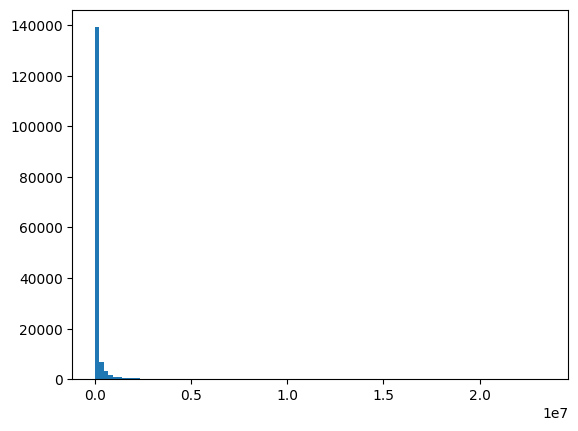

In [88]:
near_diff = np.max(np.abs(gray_ls[idx] - np.expand_dims(gray_ls, -1)) / (ds + 1e-5), axis=1)
plt.hist(near_diff, bins=100)

mean = np.mean(near_diff)
std = np.std(near_diff)

f"std {np.std(near_diff)} mean {np.mean(near_diff)} min {np.min(near_diff)} max {np.max(near_diff)}"

In [89]:
import pyvista as pv

scene = pv.Plotter()
cloud = pv.PolyData(vertex_ls[near_diff > mean + std])
scene.add_mesh(cloud, point_size=5)
scene.add_mesh(mesh_ls[0])
scene.camera_position = 'xy'
scene.show()

Widget(value="<iframe src='http://localhost:55120/index.html?ui=P_0x7f8e2ea1ffa0_28&reconnect=auto' style='wid…